In [ ]:
import torch
import pandas as pd
import numpy as np
import re

from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm


c:\Users\Acer\.conda\envs\nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
file_path = "test.ft (1).txt"   # adjust path if needed

labels = []
texts = []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        label, text = line.split(" ", 1)
        labels.append(int(label.replace("__label__", "")))
        texts.append(text)

df = pd.DataFrame({"label": labels, "review": texts})
print(df.head())
print(df.shape)


   label                                             review
0      2  Great CD: My lovely Pat has one of the GREAT v...
1      2  One of the best game music soundtracks - for a...
2      1  Batteries died within a year ...: I bought thi...
3      2  works fine, but Maha Energy is better: Check o...
4      2  Great for the non-audiophile: Reviewed quite a...
(400000, 2)


In [ ]:
df.isnull().sum()

label     0
review    0
dtype: int64

In [ ]:
df.describe()

,label
count,400000.000000
mean,1.500000
std,0.500001
min,1.000000
25%,1.000000
50%,1.500000
75%,2.000000
max,2.000000


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.strip()

df["clean_review"] = df["review"].apply(clean_text)
df["review_length"] = df["clean_review"].apply(lambda x: len(x.split()))


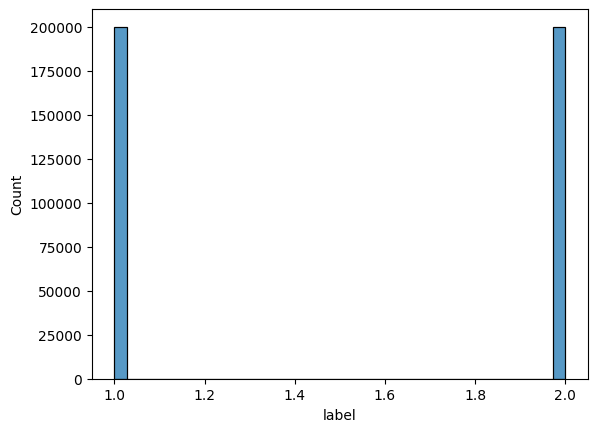

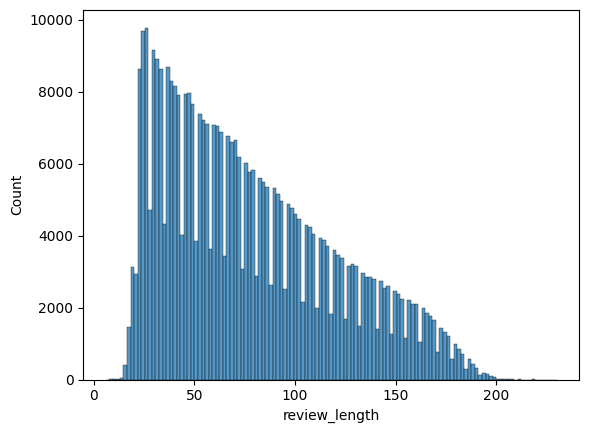

In [ ]:
import matplotlib.pyplot  as plt
import seaborn as sns
sns.histplot(df['label'])
plt.show()
sns.histplot(df['review_length'])
plt.show()

In [ ]:
# Original: 1 = negative, 2 = positive
def to_3class(row):
    if row["label"] == 1 and row["review_length"] <= 8:
        return 1   # Neutral
    elif row["label"] == 1:
        return 0   # Negative
    else:
        return 2   # Positive

df["sentiment"] = df.apply(to_3class, axis=1)
print(df["sentiment"].value_counts())


sentiment
2    200000
0    199998
1         2
Name: count, dtype: int64


In [ ]:
SAMPLES_PER_CLASS = 4000   # safe size (~15k total)

df_small = df.groupby("sentiment", group_keys=False).apply(
    lambda x: x.sample(
        n=min(len(x), SAMPLES_PER_CLASS),
        random_state=42
    )
).reset_index(drop=True)

print(df_small["sentiment"].value_counts())


sentiment
0    4000
2    4000
1       2
Name: count, dtype: int64


C:\Users\Acer\AppData\Local\Temp\ipykernel_40764\1727502569.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby("sentiment", group_keys=False).apply(


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df_small["clean_review"].tolist(),
    df_small["sentiment"].tolist(),
    test_size=0.35,
    random_state=42,
    shuffle=True
)


NameError: name 'train_test_split' is not defined

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

MAX_LEN = 32

train_enc = tokenizer(
    X_train, truncation=True, padding=True, max_length=MAX_LEN
)

val_enc = tokenizer(
    X_val, truncation=True, padding=True, max_length=MAX_LEN
)


In [ ]:
test_encodings = tokenizer(
    list(X_val),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [ ]:
test_dataset = SentimentDataset(test_encodings, y_val)

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True
)

In [ ]:
BATCH_SIZE = 8

train_ds = SentimentDataset(train_enc, y_train)
val_ds   = SentimentDataset(val_enc, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
).to(device)


Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

total_steps = len(train_loader) * 2  # 2 epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
EPOCHS = 2

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())

    acc = accuracy_score(labels, preds)
    print(f"Epoch {epoch+1} Validation Accuracy: {acc:.4f}\n")


Epoch 1/2: 100%|██████████| 701/701 [00:57<00:00, 12.20it/s]


Epoch 1 Train Loss: 0.3994
Epoch 1 Validation Accuracy: 0.8830



Epoch 2/2: 100%|██████████| 701/701 [00:53<00:00, 13.20it/s]


Epoch 2 Train Loss: 0.1912
Epoch 2 Validation Accuracy: 0.8892



In [ ]:
"""# SAVE MODEL & TOKENIZER
SAVE_PATH = "./sentiment_distilbert_3class"

model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

print("Model & tokenizer saved at:", SAVE_PATH)"""


'# SAVE MODEL & TOKENIZER\nSAVE_PATH = "./sentiment_distilbert_3class"\n\nmodel.save_pretrained(SAVE_PATH)\ntokenizer.save_pretrained(SAVE_PATH)\n\nprint("Model & tokenizer saved at:", SAVE_PATH)'

In [ ]:
"""from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

model = DistilBertForSequenceClassification.from_pretrained(SAVE_PATH)
tokenizer = DistilBertTokenizerFast.from_pretrained(SAVE_PATH)

model.to(device)
model.eval()

print(" Model reloaded successfully")
"""

'from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast\n\nmodel = DistilBertForSequenceClassification.from_pretrained(SAVE_PATH)\ntokenizer = DistilBertTokenizerFast.from_pretrained(SAVE_PATH)\n\nmodel.to(device)\nmodel.eval()\n\nprint(" Model reloaded successfully")\n'

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import torch
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")


C:\Users\Acer\AppData\Local\Temp\ipykernel_40764\1559355572.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}



Test Accuracy: 0.9055


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels,
    all_preds,
    labels=[0, 1, 2],
    target_names=["Negative", "Neutral", "Positive"],
    zero_division=0
))


              precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      1226
     Neutral       0.00      0.00      0.00         0
    Positive       0.90      0.91      0.90      1175

    accuracy                           0.91      2401
   macro avg       0.60      0.60      0.60      2401
weighted avg       0.91      0.91      0.91      2401



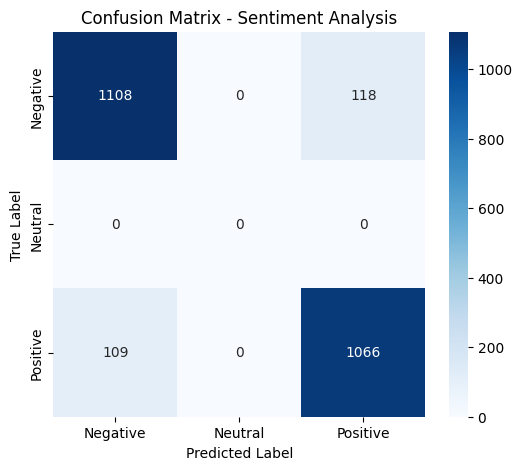

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = [0, 1, 2]
class_names = ["Negative", "Neutral", "Positive"]

cm = confusion_matrix(all_labels, all_preds, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Sentiment Analysis")
plt.show()


# Testing real life Reviews

In [ ]:
sentiment_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}


In [ ]:
def predict_real_reviews(texts):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )

    encodings = {k: v.to(device) for k, v in encodings.items()}

    with torch.no_grad():
        outputs = model(**encodings)
        preds = torch.argmax(outputs.logits, dim=1)

    return [sentiment_map[p.item()] for p in preds]


In [ ]:
real_reviews = [
    "The product stopped working after two weeks. Very disappointed.",
    "Delivery was on time, product is okay but nothing special.",
    "Absolutely love this product! Worth every rupee.",
    "Battery life is poor and customer support is useless.",
    "Packaging was damaged but the product works fine."
]

predictions = predict_real_reviews(real_reviews)

for r, p in zip(real_reviews, predictions):
    print(f"Review: {r}")
    print(f"Predicted Sentiment: {p}\n")



Review: The product stopped working after two weeks. Very disappointed.
Predicted Sentiment: Negative

Review: Delivery was on time, product is okay but nothing special.
Predicted Sentiment: Negative

Review: Absolutely love this product! Worth every rupee.
Predicted Sentiment: Positive

Review: Battery life is poor and customer support is useless.
Predicted Sentiment: Negative

Review: Packaging was damaged but the product works fine.
Predicted Sentiment: Negative



# Predict low rated products before sale declined

In [ ]:
import torch
import numpy as np
from transformers import DistilBertTokenizerFast
import pandas as pd

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sentiment(texts, batch_size=32):
    sentiments = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors="pt"
        )

        encodings = {k: v.to(device) for k, v in encodings.items()}

        with torch.no_grad():
            outputs = model(**encodings)
            preds = torch.argmax(outputs.logits, dim=1)

        sentiments.extend(preds.cpu().numpy())

    return sentiments


In [ ]:
df.columns


Index(['label', 'review', 'clean_review', 'review_length', 'sentiment'], dtype='object')

In [ ]:
import pandas as pd
from tqdm import tqdm  # optional, to show progress

# Example predict_sentiment function
# Replace this with your actual model/function
def predict_sentiment(reviews):
    # Dummy example: returns 0 (negative) if "bad" in review, 2 (positive) if "good" in review, else 1
    preds = []
    for r in reviews:
        r = r.lower()
        if "bad" in r:
            preds.append(0)
        elif "good" in r:
            preds.append(2)
        else:
            preds.append(1)
    return preds

# =========================
# Batch processing for 400k reviews
# =========================
batch_size = 5000  # adjust based on your RAM
predictions = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_reviews = df["clean_review"].iloc[i:i+batch_size].astype(str).tolist()
    batch_preds = predict_sentiment(batch_reviews)
    predictions.extend(batch_preds)

df["predicted_sentiment"] = predictions



100%|██████████| 80/80 [00:00<00:00, 115.36it/s]


In [ ]:
sentiment_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

df["predicted_label"] = df["predicted_sentiment"].map(sentiment_map)


In [ ]:
# Flag risky reviews
df["risk_flag"] = df["predicted_sentiment"].apply(
    lambda x: "RISK" if x == 0 else "SAFE"
)


In [ ]:
df[df["risk_flag"] == "RISK"].head(10)


,label,review,clean_review,review_length,sentiment,predicted_sentiment,predicted_label,risk_flag
0,2,Great CD: My lovely Pat has one of the GREAT v...,great cd my lovely pat has one of the great vo...,105,2,0,Negative,RISK
5,1,DVD Player crapped out after one year: I also ...,dvd player crapped out after one year i also b...,73,0,0,Negative,RISK
31,2,Mary Ash: Can't believe I have never reviewed ...,mary ash cant believe i have never reviewed th...,88,2,0,Negative,RISK
40,2,WeiB FOREVER!: This is a great CD!! I love Wei...,weib forever this is a great cd i love weib kr...,106,2,0,Negative,RISK
43,2,Marriage has its good and bad moments: This is...,marriage has its good and bad moments this is ...,102,2,0,Negative,RISK
44,2,Amazing...: love it...very touch.it's to bad t...,amazing love itvery touchits to bad that in th...,15,2,0,Negative,RISK
46,1,More Romance Please and Less Mystery!!: the re...,more romance please and less mystery the reaso...,173,0,0,Negative,RISK
48,1,Okay but Messy....: We purchased this bag for ...,okay but messy we purchased this bag for a vac...,89,0,0,Negative,RISK
52,1,12 Y/O Potty Humor From 40 somethings does not...,12 yo potty humor from 40 somethings does not ...,118,0,0,Negative,RISK
84,1,Avoid it.: The abridged version of this book w...,avoid it the abridged version of this book wou...,109,0,0,Negative,RISK


# Help sellers improve products using review insights

In [ ]:
df.head()


,label,review,clean_review,review_length,sentiment,predicted_sentiment,predicted_label,risk_flag
0,2,Great CD: My lovely Pat has one of the GREAT v...,great cd my lovely pat has one of the great vo...,105,2,0,Negative,RISK
1,2,One of the best game music soundtracks - for a...,one of the best game music soundtracks for a ...,147,2,1,Neutral,SAFE
2,1,Batteries died within a year ...: I bought thi...,batteries died within a year i bought this ch...,59,0,1,Neutral,SAFE
3,2,"works fine, but Maha Energy is better: Check o...",works fine but maha energy is better check out...,37,2,1,Neutral,SAFE
4,2,Great for the non-audiophile: Reviewed quite a...,great for the nonaudiophile reviewed quite a b...,69,2,1,Neutral,SAFE


In [ ]:
import pandas as pd
from collections import Counter
import re

# Focus on RISK products
risk_reviews = df[df["risk_flag"] == "RISK"]

In [ ]:
# Combine all RISK reviews into one for analysis
 
all_risk_text = " ".join(risk_reviews["clean_review"].astype(str).tolist())


In [ ]:
# Extract top complaint keywords
 
def get_top_keywords(text, top_n=10):
    # Lowercase, remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())
    # Stopwords to ignore common words
    stopwords = set([
        'the','and','for','with','this','that','was','but','not',
        'very','product','good','great','excellent','purchase','i'
    ])
    words = [w for w in words if w not in stopwords]
    counter = Counter(words)
    return counter.most_common(top_n)

top_complaints = get_top_keywords(all_risk_text, top_n=15)


In [ ]:
# Summary for sellers
 
summary = {
    "total_risk_reviews": len(risk_reviews),
    "average_rating": risk_reviews["label"].mean(),
    "top_complaints_keywords": [k for k,_ in top_complaints]
}

print("===== Seller Insights =====")
print(f"Total RISK reviews: {summary['total_risk_reviews']}")
print(f"Average rating of RISK reviews: {summary['average_rating']:.2f}")
print("Top complaints / keywords:", summary["top_complaints_keywords"])

===== Seller Insights =====
Total RISK reviews: 29037
Average rating of RISK reviews: 1.24
Top complaints / keywords: ['a', 'to', 'it', 'of', 'is', 'bad', 'in', 'you', 'on', 'have', 'are', 'as', 'my', 'book', 'one']


# Improve customers experience & Product ranking

In [ ]:
#  Compute product metrics
 
total_reviews = len(df)
risk_reviews = df[df["risk_flag"] == "RISK"]
safe_reviews = df[df["risk_flag"] == "SAFE"]

# Average ratings
avg_rating_all = df["label"].mean()
avg_rating_risk = risk_reviews["label"].mean() if not risk_reviews.empty else 0

# Fraction of negative reviews
neg_fraction = (df["predicted_sentiment"] == 0).mean()
neg_fraction_risk = (risk_reviews["predicted_sentiment"] == 0).mean() if not risk_reviews.empty else 0


In [ ]:
# Extract top complaints from RISK reviews
 
def get_top_keywords(text, top_n=10):
    words = re.findall(r'\b\w+\b', text.lower())
    stopwords = set([
        'the','and','for','with','this','that','was','but','not',
        'very','product','good','great','excellent','purchase','i'
    ])
    words = [w for w in words if w not in stopwords]
    counter = Counter(words)
    return counter.most_common(top_n)

if not risk_reviews.empty:
    all_risk_text = " ".join(risk_reviews["clean_review"].astype(str).tolist())
    top_complaints = get_top_keywords(all_risk_text, top_n=15)
else:
    top_complaints = []

In [ ]:
# Generate product improvement suggestions
 
keyword_suggestions = {
    'battery': 'Improve battery life',
    'noise': 'Reduce product noise',
    'quality': 'Enhance product build quality',
    'broken': 'Check manufacturing defects',
    'delay': 'Improve delivery speed',
    'faulty': 'Fix recurring product faults',
    'cheap': 'Upgrade material quality',
    'return': 'Simplify return process',
    'disappoint': 'Enhance overall user experience',
    'stop': 'Fix unexpected product stoppages'
}

suggestions = [keyword_suggestions.get(k, f"Investigate issue: {k}") for k,_ in top_complaints]


In [ ]:
# Print actionable insights

print("===== Customer Experience & Product Ranking Insights =====")
print(f"Total reviews: {total_reviews}")
print(f"Average rating (all reviews): {avg_rating_all:.2f}")
print(f"Average rating (RISK reviews): {avg_rating_risk:.2f}")
print(f"Fraction of negative reviews (all): {neg_fraction:.2%}")
print(f"Fraction of negative reviews (RISK): {neg_fraction_risk:.2%}")
print("Top complaints from RISK reviews:", [k for k,_ in top_complaints])
print("Suggested actions to improve product & experience:")
for s in suggestions:
    print("-", s)

===== Customer Experience & Product Ranking Insights =====
Total reviews: 400000
Average rating (all reviews): 1.50
Average rating (RISK reviews): 1.24
Fraction of negative reviews (all): 7.26%
Fraction of negative reviews (RISK): 100.00%
Top complaints from RISK reviews: ['a', 'to', 'it', 'of', 'is', 'bad', 'in', 'you', 'on', 'have', 'are', 'as', 'my', 'book', 'one']
Suggested actions to improve product & experience:
- Investigate issue: a
- Investigate issue: to
- Investigate issue: it
- Investigate issue: of
- Investigate issue: is
- Investigate issue: bad
- Investigate issue: in
- Investigate issue: you
- Investigate issue: on
- Investigate issue: have
- Investigate issue: are
- Investigate issue: as
- Investigate issue: my
- Investigate issue: book
- Investigate issue: one
